# **ICESat-2 Active Subglacial Lakes in Antarctica**

Finding subglacial lakes that are draining or filling under the ice!
They can be detected with ICESat-2 data, as significant changes in height
(> 1 metre) over a relatively short duration (< 1 year), i.e. a high rate of
elevation change over time (dhdt).

In this notebook, we'll use some neat tools to help us examine the lakes:
- To find active subglacial lake boundaries,
use an *unsupervised clustering* technique
- To see ice surface elevation trends at a higher temporal resolution (< 3 months),
perform *crossover track error analysis* on intersecting ICESat-2 tracks

To speed up analysis on millions of points,
we will use state of the art GPU algorithms enabled by RAPIDS AI libraries,
or parallelize the processing across our HPC's many CPU cores using Dask.

In [1]:
import os
import subprocess

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import cudf
import cuml
import dask
import dask.array
import geopandas as gpd
import hvplot.xarray
import numpy as np
import pandas as pd
import panel as pn
import pygmt
import scipy.spatial
import shapely.geometry
import tqdm
import xarray as xr
import zarr

import deepicedrain

In [ ]:
use_cupy: bool = True
if use_cupy:
    import cupy
    import dask_cuda
    import dask_cudf

    cluster = dask_cuda.LocalCUDACluster(n_workers=2, threads_per_worker=1)
else:
    cluster = dask.distributed.LocalCluster(n_workers=8, threads_per_worker=1)

client = dask.distributed.Client(address=cluster)
client

# Data Preparation

In [3]:
if not os.path.exists("ATLXI/df_dhdt_antarctica.parquet"):
    zarrarray = zarr.open_consolidated(store=f"ATLXI/ds_dhdt_antarctica.zarr", mode="r")
    _ = deepicedrain.ndarray_to_parquet(
        ndarray=zarrarray,
        parquetpath="ATLXI/df_dhdt_antarctica.parquet",
        variables=["x", "y", "dhdt_slope", "referencegroundtrack"],  # "h_corr"],
        dropnacols=["dhdt_slope"],
    )

In [4]:
# Read in Antarctic Drainage Basin Boundaries shapefile into a GeoDataFrame
ice_boundaries: gpd.GeoDataFrame = (
    deepicedrain.catalog.measures_antarctic_boundaries.read()
)
drainage_basins: gpd.GeoDataFrame = ice_boundaries.query(expr="TYPE == 'GR'")

## Load in ICESat-2 data (x, y, dhdt) and do initial trimming

In [5]:
# Read in raw x, y, dhdt_slope and referencegroundtrack data into the GPU
cudf_raw: cudf.DataFrame = dask_cudf.read_parquet(
    path="ATLXI/df_dhdt_antarctica.parquet",
    columns=["x", "y", "dhdt_slope", "referencegroundtrack"],
    # filters=[[('dhdt_slope', '<', -0.105)], [('dhdt_slope', '>', 0.105)]],
)
# Filter to points with dhdt that is less than -0.105 m/yr or more than +0.105 m/yr
# Based on ICESat-2 ATL06's accuracy and precision of 3.3 ± 7.2cm from Brunt et al 2020
# See https://doi.org/10.1029/2020GL090572
cudf_many = cudf_raw.loc[abs(cudf_raw.dhdt_slope) > 0.105].compute()
print(f"Trimmed {len(cudf_raw)} -> {len(cudf_many)}")
if "cudf_raw" in globals():
    del cudf_raw

Trimmed 288357656 -> 92154523


In [6]:
# Clip outlier values to 3 sigma (standard deviations) from mean
_mean = cudf_many.dhdt_slope.mean()
_std = cudf_many.dhdt_slope.std()
cudf_many.dhdt_slope.clip(
    lower=np.float32(_mean - 3 * _std), upper=np.float32(_mean + 3 * _std), inplace=True
)

## Label ICESat-2 points according to their drainage basin

Uses Point in Polygon.
For each point, find out which Antarctic Drainage Basin they are in.
This will also remove the points on floating (FR) ice shelves and islands (IS),
so that we keep only points on the grounded (GR) ice regions.

In [7]:
# Use point in polygon to label points according to the drainage basins they fall in
cudf_many["drainage_basin"]: cudf.Series = deepicedrain.point_in_polygon_gpu(
    points_df=cudf_many, poly_df=drainage_basins, poly_limit=16
)
X_many = cudf_many.dropna()  # drop points that are not in a drainage basin
print(f"Trimmed {len(cudf_many)} -> {len(X_many)}")

Trimmed 92154523 -> 58567001


# Find Active Subglacial Lake clusters

Uses Density-based spatial clustering of applications with noise (DBSCAN).

### Subglacial Lake Finder algorithm

For each Antarctic drainage basin:

1. Select all points with significant elevation change over time (dhdt)
  - Specifically, the (absolute) dhdt value should be
    2x the median (absolute) dhdt for that drainage basin
  - E.g. if median dhdt for basin is 0.35 m/yr,
    we choose points that have dhdt > 0.70 m/yr
2. Run unsupervised clustering to pick out active subglacial lakes
  - Split into draining (-dhdt) and filling (+dhdt) points first
  - Use DBSCAN algorithm to cluster points into groups,
    with an eps (distance) of 3 km and minimum sample size of 250 points
3. Check each potential point cluster to see if it meets active lake criteria
  1. Build a convex hull 'lake' polygon around clustered points
  2. Check that the 'lake' has significant elevation change relative to outside
    - For the area in the 5 km buffer region **outside** the 'lake' polygon:
       - Find median dhdt (outer_dhdt)
       - Find median absolute deviation of dhdt values (outer_mad)
    - For the area **inside** the 'lake' polygon:
       - Find median dhdt (inner_dhdt)
    - If the potential lake shows an elevation change that is more than
      3x the surrounding deviation of background elevation change,
      we infer that this is likely an active subglacial 'lake'

In [8]:
# Subglacial lake finder
activelakes: dict = {
    "basin_name": [],  # Antarctic drainage basin name
    "refgtracks": [],  # Pipe-delimited list of ICESat-2 reference ground tracks
    "num_points": [],  # Number of clustered data points
    "maxabsdhdt": [],  # Maximum absolute dhdt value inside of lake boundary
    "inner_dhdt": [],  # Median elev change over time (dhdt) inside of lake bounds
    "mean_dhdt": [],  # Mean elev change over time (dhdt) inside of lake bounds
    "outer_dhdt": [],  # Median elevation change over time (dhdt) outside of lake
    "outer_std": [],  # Standard deviation of dhdt outside of lake
    "outer_mad": [],  # Median absolute deviation of dhdt outside of lake
    "geometry": [],  # Shapely Polygon geometry holding lake boundary coordinates
}
basin_name: str = "Cook"  # Set a basin name here
basins = drainage_basins[drainage_basins.NAME == basin_name].index  # one specific basin
# basins = drainage_basins[
#     drainage_basins.NAME.isin(("Cook", "Whillans"))
# ].index  # some specific basins
basins: pd.core.indexes.numeric.Int64Index = drainage_basins.index  # run on all basins

eps: int = 3000  # ICESat-2 tracks are separated by ~3 km across track, with each laser pair ~90 m apart
min_samples: int = 300
for basin_index in tqdm.tqdm(iterable=basins):
    # Initial data cleaning, filter to rows that are in the drainage basin
    basin = drainage_basins.loc[basin_index]
    X_local = X_many.loc[X_many.drainage_basin == basin.NAME]  # .reset_index(drop=True)

    # Get points with dhdt_slope higher than 3x the median dhdt_slope for the basin
    # E.g. if median dhdt_slope is 0.30 m/yr, then we cluster points over 0.90 m/yr
    abs_dhdt = X_local.dhdt_slope.abs()
    tolerance: float = 3 * abs_dhdt.median()
    X = X_local.loc[abs_dhdt > tolerance]

    if len(X) <= 1000:  # don't run on too few points
        continue

    # Run unsupervised clustering separately on draining and filling lakes
    # Draining lake points have negative labels (e.g. -1, -2, 3),
    # Filling lake points have positive labels (e.g. 1, 2, 3),
    # Noise points have NaN labels (i.e. NaN)
    cluster_vars = ["x", "y", "dhdt_slope"]
    draining_lake_labels = -deepicedrain.find_clusters(
        X=X.loc[X.dhdt_slope < 0][cluster_vars],
        eps=eps,
        min_samples=min_samples,
        verbose=cuml.common.logger.level_error,
    )
    filling_lake_labels = deepicedrain.find_clusters(
        X=X.loc[X.dhdt_slope > 0][cluster_vars],
        eps=eps,
        min_samples=min_samples,
        verbose=cuml.common.logger.level_error,
    )
    lake_labels = cudf.concat(objs=[draining_lake_labels, filling_lake_labels])
    lake_labels: cudf.Series = lake_labels.sort_index()
    assert lake_labels.name == "cluster_id"

    # Checking all potential subglacial lakes in a basin
    clusters: cudf.Series = lake_labels.unique()
    for cluster_label in clusters.to_array():
        # Store attribute and geometry information of each active lake
        lake_points: cudf.DataFrame = X.loc[lake_labels == cluster_label]

        # More data cleaning, dropping clusters with too few points
        try:
            assert len(lake_points) > 100
        except AssertionError:
            lake_labels = lake_labels.replace(to_replace=cluster_label, value=None)
            continue

        multipoint: shapely.geometry.MultiPoint = shapely.geometry.MultiPoint(
            points=lake_points[["x", "y"]].as_matrix()
        )
        convexhull: shapely.geometry.Polygon = multipoint.convex_hull

        # Filter out (most) false positive subglacial lakes
        # Check that elevation change over time in lake is anomalous to outside
        # The 5000 m distance from lake boundary setting is empirically based on
        # Smith et al. 2009's methodology at https://doi.org/10.3189/002214309789470879
        outer_ring_buffer = convexhull.buffer(distance=5000) - convexhull
        X_local["in_donut_ring"] = deepicedrain.point_in_polygon_gpu(
            points_df=X_local,
            poly_df=gpd.GeoDataFrame({"name": True, "geometry": [outer_ring_buffer]}),
        )
        outer_points = X_local.dropna(subset="in_donut_ring")
        outer_dhdt: float = outer_points.dhdt_slope.median()

        outer_std: float = outer_points.dhdt_slope.std()
        outer_mad: float = scipy.stats.median_abs_deviation(
            x=outer_points.dhdt_slope.to_pandas()
        )

        mean_dhdt: float = lake_points.dhdt_slope.mean()
        inner_dhdt: float = lake_points.dhdt_slope.median()
        X_local = X_local.drop(labels="in_donut_ring", axis="columns")

        # If lake interior's median dhdt value is within 3 median absolute deviations
        # of the lake exterior's dhdt value, we remove the lake label
        # I.e. skip if above background change not significant enough
        # Inspired by Kim et al. 2016's methodology at https://doi.org/10.5194/tc-10-2971-2016
        if abs(inner_dhdt - outer_dhdt) < 3 * outer_mad:
            lake_labels = lake_labels.replace(to_replace=cluster_label, value=None)
            continue

        maxabsdhdt: float = (
            lake_points.dhdt_slope.max()
            if cluster_label > 0  # positive label = filling
            else lake_points.dhdt_slope.min()  # negative label = draining
        )
        refgtracks: str = "|".join(
            map(str, lake_points.referencegroundtrack.unique().to_pandas())
        )

        # Save key variables to dictionary that will later go into geodataframe
        activelakes["basin_name"].append(basin.NAME)
        activelakes["refgtracks"].append(refgtracks)
        activelakes["num_points"].append(len(lake_points))
        activelakes["maxabsdhdt"].append(maxabsdhdt)
        activelakes["inner_dhdt"].append(inner_dhdt)
        activelakes["mean_dhdt"].append(mean_dhdt)
        activelakes["outer_dhdt"].append(outer_dhdt)
        activelakes["outer_std"].append(outer_std)
        activelakes["outer_mad"].append(outer_mad)
        activelakes["geometry"].append(convexhull)

    # Calculate total number of lakes found for one drainage basin
    clusters: cudf.Series = lake_labels.unique()
    n_draining, n_filling = (clusters < 0).sum(), (clusters > 0).sum()
    if n_draining + n_filling > 0:
        print(f"{len(X)} rows at {basin.NAME} above ± {tolerance:.2f} m/yr")
        print(f"{n_draining} draining and {n_filling} filling lakes found")

if len(activelakes["geometry"]) >= 1:
    gdf = gpd.GeoDataFrame(activelakes, crs="EPSG:3031")
    basename = "antarctic_subglacial_lakes"  # f"temp_{basin_name.lower()}_lakes"  #
    gdf.to_file(filename=f"{basename}_3031.geojson", driver="GeoJSON")
    gdf.to_crs(crs={"init": "epsg:4326"}).to_file(
        filename=f"{basename}_4326.geojson", driver="GeoJSON"
    )

print(f"Total of {len(gdf)} subglacial lakes found")

  1%|          | 2/198 [00:01<01:54,  1.71it/s]

103719 rows at Academy above ± 0.44 m/yr
2 draining and 8 filling lakes found


  8%|▊         | 15/198 [00:02<00:27,  6.68it/s]

46248 rows at Jutulstraumen above ± 0.60 m/yr
0 draining and 1 filling lakes found


 28%|██▊       | 56/198 [00:05<00:11, 12.16it/s]

52138 rows at Cook above ± 0.50 m/yr
0 draining and 1 filling lakes found
34258 rows at David above ± 0.48 m/yr
1 draining and 1 filling lakes found


 31%|███       | 61/198 [00:07<00:31,  4.34it/s]

100291 rows at Mercer above ± 0.56 m/yr
4 draining and 16 filling lakes found


 32%|███▏      | 63/198 [00:13<02:34,  1.14s/it]

275183 rows at Pine_Island above ± 1.03 m/yr
2 draining and 0 filling lakes found


 34%|███▍      | 68/198 [00:16<02:18,  1.06s/it]

187423 rows at Thwaites above ± 0.83 m/yr
3 draining and 3 filling lakes found


 35%|███▌      | 70/198 [00:16<01:37,  1.32it/s]

128815 rows at Whillans above ± 0.67 m/yr
6 draining and 18 filling lakes found


 36%|███▋      | 72/198 [00:19<02:09,  1.03s/it]

63115 rows at Kamb above ± 0.57 m/yr
2 draining and 12 filling lakes found
7812 rows at Leverett above ± 0.64 m/yr
2 draining and 0 filling lakes found


 37%|███▋      | 74/198 [00:20<01:51,  1.11it/s]

87845 rows at Scott above ± 0.52 m/yr
3 draining and 12 filling lakes found


 39%|███▉      | 77/198 [00:21<01:13,  1.65it/s]

60754 rows at Amundsen above ± 0.50 m/yr
2 draining and 7 filling lakes found


 40%|████      | 80/198 [00:22<00:44,  2.62it/s]

81617 rows at Beardmore above ± 0.46 m/yr
0 draining and 2 filling lakes found


 41%|████▏     | 82/198 [00:22<00:38,  3.01it/s]

67014 rows at Nimrod above ± 0.46 m/yr
2 draining and 0 filling lakes found


 43%|████▎     | 86/198 [00:23<00:32,  3.45it/s]

109973 rows at Byrd above ± 0.46 m/yr
6 draining and 5 filling lakes found


 44%|████▍     | 88/198 [00:23<00:24,  4.56it/s]

34959 rows at Bindschadler above ± 0.48 m/yr
2 draining and 1 filling lakes found


 46%|████▋     | 92/198 [00:24<00:21,  4.83it/s]

56466 rows at MacAyeal above ± 0.49 m/yr
4 draining and 2 filling lakes found


 55%|█████▌    | 109/198 [00:25<00:06, 12.90it/s]

10634 rows at Bailey above ± 0.50 m/yr
0 draining and 1 filling lakes found
54763 rows at Slessor above ± 0.47 m/yr
12 draining and 4 filling lakes found


 57%|█████▋    | 112/198 [00:27<00:14,  6.00it/s]

35202 rows at Support_Force above ± 0.44 m/yr
3 draining and 1 filling lakes found


 58%|█████▊    | 114/198 [00:28<00:27,  3.05it/s]

92281 rows at Foundation above ± 0.44 m/yr
1 draining and 15 filling lakes found


 59%|█████▉    | 117/198 [00:28<00:20,  3.86it/s]

23334 rows at Lambert above ± 0.41 m/yr
0 draining and 1 filling lakes found
21702 rows at Mellor above ± 0.48 m/yr
1 draining and 1 filling lakes found


 61%|██████    | 121/198 [00:29<00:12,  5.97it/s]

10129 rows at Fisher above ± 0.48 m/yr
0 draining and 1 filling lakes found


 67%|██████▋   | 133/198 [00:29<00:05, 12.74it/s]

10182 rows at Moller above ± 0.47 m/yr
1 draining and 0 filling lakes found


 68%|██████▊   | 135/198 [00:30<00:09,  6.49it/s]

37732 rows at Institute above ± 0.48 m/yr
8 draining and 3 filling lakes found


 72%|███████▏  | 142/198 [00:31<00:09,  6.19it/s]

30625 rows at Bowman_Strom_Live_Axel-Heigerg above ± 0.81 m/yr
1 draining and 0 filling lakes found
32760 rows at Sulzberger above ± 0.88 m/yr
1 draining and 0 filling lakes found


 83%|████████▎ | 165/198 [00:34<00:04,  7.21it/s]

76812 rows at Recovery above ± 0.43 m/yr
3 draining and 6 filling lakes found


100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Total of 194 subglacial lakes found


## Visualize lakes

In [9]:
# Concatenate XY points with labels, and move data from GPU to CPU
X: cudf.DataFrame = cudf.concat(objs=[X, lake_labels], axis="columns")
X_ = X.to_pandas()

In [ ]:
# Plot clusters on a map in colour, noise points/outliers as small dots
fig = pygmt.Figure()
n_clusters_ = len(X_.cluster_id.unique()) - 1  # No. of clusters minus noise (NaN)
sizes = (X_.cluster_id.isna()).map(arg={True: 0.01, False: 0.1})
pygmt.makecpt(cmap="polar", series=(-1, 1, 2), color_model="+cDrain,Fill", reverse=True)
fig.plot(
    x=X_.x,
    y=X_.y,
    sizes=sizes,
    style="cc",
    color=pd.cut(x=X_.cluster_id, bins=(-np.inf, 0, np.inf), labels=[-1, 1]),
    cmap=True,
    frame=[
        f'WSne+t"Estimated number of lake clusters at {basin.NAME}: {n_clusters_}"',
        'xafg+l"Polar Stereographic X (m)"',
        'yafg+l"Polar Stereographic Y (m)"',
    ],
)
basinx, basiny = basin.geometry.exterior.coords.xy
fig.plot(x=basinx, y=basiny, pen="thinnest,-")
fig.colorbar(position='JMR+w2c/0.5c+m+n"Unclassified"', L="i0.5c")
fig.savefig(fname=f"figures/subglacial_lake_clusters_at_{basin.NAME}.png")
fig.show()

# Select a subglacial lake to examine

In [11]:
# Save or load dhdt data from Parquet file
placename: str = "siple_coast"  # "slessor_downstream"  #  "Recovery"  # "Whillans"
df_dhdt: cudf.DataFrame = cudf.read_parquet(
    f"ATLXI/df_dhdt_{placename.lower()}.parquet"
)

index                                                         0
geometry      POLYGON ((-444773.5763656513 -545238.396390805...
basin_name                                             Whillans
refgtracks    74|135|196|266|327|388|516|577|638|769|830|891...
num_points                                                 4276
maxabsdhdt                                              7.26322
inner_dhdt                                                1.567
mean_dhdt                                               1.91527
outer_dhdt                                             0.350537
outer_std                                              0.160555
outer_mad                                             0.0827204
Name: 0, dtype: object


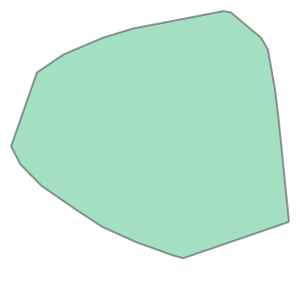

In [12]:
# Choose one Antarctic active subglacial lake polygon with EPSG:3031 coordinates
lake_name: str = "Whillans IX"
lake_catalog = deepicedrain.catalog.subglacial_lakes()
lake_ids, transect_id = (
    pd.json_normalize(lake_catalog.metadata["lakedict"])
    .query("lakename == @lake_name")[["ids", "transect"]]
    .iloc[0]
)
lake = (
    lake_catalog.read()
    .loc[lake_ids]
    .dissolve(by=np.zeros(shape=len(lake_ids), dtype="int64"), as_index=False)
    .squeeze()
)

region = deepicedrain.Region.from_gdf(gdf=lake, name=lake_name)
draining: bool = lake.inner_dhdt < 0

print(lake)
lake.geometry

In [13]:
# Subset data to lake of interest
placename: str = region.name.lower().replace(" ", "_")
df_lake: cudf.DataFrame = region.subset(data=df_dhdt)
# Get all raw xyz points and one transect line dataframe
track_dict: dict = deepicedrain.split_tracks(df=df_lake.to_pandas())
track_points: pd.DataFrame = (
    pd.concat(track_dict.values())
    .groupby(by=["x", "y"])
    .mean()  # z value is mean h_corr over all cycles
    .reset_index()[["x", "y", "h_corr"]]
)
try:
    _rgt, _pt = transect_id.split("_")
    df_transect: pd.DataFrame = (
        track_dict[transect_id][["x", "y", "h_corr", "cycle_number"]]
        .groupby(by=["x", "y"])
        .max()  # z value is maximum h_corr over all cycles
        .reset_index()
    )
except AttributeError:
    pass

# Save lake outline to OGR GMT file format
outline_points: str = f"figures/{placename}/{placename}.gmt"
if not os.path.exists(path=outline_points):
    os.makedirs(name=f"figures/{placename}", exist_ok=True)
    lake_catalog.read().loc[list(lake_ids)].to_file(
        filename=outline_points, driver="OGR_GMT"
    )

100%|██████████| 21/21 [00:00<00:00, 36.83it/s]


## Create an interpolated ice surface elevation grid for each ICESat-2 cycle

In [17]:
# Generate gridded time-series of ice elevation over lake
cycles: tuple = (3, 4, 5, 6, 7, 8, 9)
os.makedirs(name=f"figures/{placename}", exist_ok=True)
ds_lake: xr.Dataset = deepicedrain.spatiotemporal_cube(
    table=df_lake.to_pandas(),
    placename=placename,
    cycles=cycles,
    folder=f"figures/{placename}",
)
ds_lake.to_netcdf(path=f"figures/{placename}/xyht_{placename}.nc", mode="w")

100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


In [18]:
# Get 3D grid_region (xmin/xmax/ymin/ymax/zmin/zmax),
# and calculate normalized z-values as Elevation delta relative to Cycle 3
z_limits: tuple = (float(ds_lake.z.min()), float(ds_lake.z.max()))  # original z limits
grid_region: tuple = region.bounds() + z_limits

ds_lake_diff: xr.Dataset = ds_lake - ds_lake.sel(cycle_number=3).z
z_diff_limits: tuple = (float(ds_lake_diff.z.min()), float(ds_lake_diff.z.max()))
diff_grid_region: np.ndarray = np.append(arr=grid_region[:4], values=z_diff_limits)

print(f"Elevation limits are: {z_limits}")

Elevation limits are: (273.2418518066406, 310.9927062988281)


In [ ]:
# 3D plot of mean ice surface elevation (<z>) and rate of ice elevation change (dhdt)
fig = deepicedrain.plot_icesurface(
    grid=f"figures/{placename}/xyht_{placename}.nc?z_mean",
    grid_region=grid_region,
    diff_grid=f"figures/{placename}/xyht_{placename}.nc?dhdt",
    track_points=track_points.to_numpy(),
    outline_points=outline_points,
    azimuth=157.5,  # 202.5  # 270
    elevation=45,  # 60
    title=f"{region.name} Ice Surface",
)
# Plot crossing transect line
fig.plot3d(
    data=df_transect[["x", "y", "h_corr"]].to_numpy(),
    color="yellow2",
    style="c0.1c",
    zscale=True,
    perspective=True,
)
fig.savefig(f"figures/{placename}/dsm_{placename}_cycles_{cycles[0]}-{cycles[-1]}.png")
fig.show()

In [ ]:
# 3D plots of gridded ice surface elevation over time (one per cycle)
for cycle in tqdm.tqdm(iterable=cycles):
    time_nsec: pd.Timestamp = df_lake[f"utc_time_{cycle}"].to_pandas().mean()
    time_sec: str = np.datetime_as_string(arr=time_nsec.to_datetime64(), unit="s")

    # grid = ds_lake.sel(cycle_number=cycle).z
    fig = deepicedrain.plot_icesurface(
        grid=f"figures/{placename}/h_corr_{placename}_cycle_{cycle}.nc",
        grid_region=grid_region,
        diff_grid=ds_lake_diff.sel(cycle_number=cycle).z,
        diff_grid_region=diff_grid_region,
        track_points=df_lake[["x", "y", f"h_corr_{cycle}"]].dropna().as_matrix(),
        outline_points=outline_points,
        azimuth=157.5,  # 202.5  # 270
        elevation=45,  # 60
        title=f"{region.name} at Cycle {cycle} ({time_sec})",
    )
    fig.savefig(f"figures/{placename}/dsm_{placename}_cycle_{cycle}.png")
fig.show()

In [ ]:
# Make an animated GIF of changing ice surface from the PNG files
# !convert -delay 120 -loop 0 figures/{placename}/dsm_*.png {gif_fname}
gif_fname: str = (
    f"figures/{placename}/dsm_{placename}_cycles_{cycles[0]}-{cycles[-1]}.gif"
)
subprocess.check_call(
    [
        "convert",
        "-delay",
        "120",
        "-loop",
        "0",
        f"figures/{placename}/dsm_*cycle_*.png",
        gif_fname,
    ]
)

In [ ]:
# HvPlot 2D interactive view of ice surface elevation grids over each ICESat-2 cycle
dashboard: pn.layout.Column = pn.Column(
    ds_lake.hvplot.image(x="x", y="y", clim=z_limits, cmap="gist_earth", data_aspect=1)
    # * ds_lake.hvplot.contour(x="x", y="y", clim=z_limits, data_aspect=1)
)
dashboard.show(port=30227)

## Along track plots of ice surface elevation change over time

In [ ]:
# Select a few Reference Ground tracks to look at
savefig_tasks: list = []  # empty list of save figure tasks
rgts: list = [int(rgt) for rgt in lake.refgtracks.split("|")]
print(f"Looking at Reference Ground Tracks: {rgts}")
track_dict: dict = deepicedrain.split_tracks(df=df_lake.to_pandas())
for rgtpair, df_ in track_dict.items():
    # Transect plot along a reference ground track
    fig = dask.delayed(obj=deepicedrain.plot_alongtrack)(
        df=df_, rgtpair=rgtpair, regionname=region.name, oldtonew=draining
    )
    savefig_task = fig.savefig(
        fname=f"figures/{placename}/alongtrack_{placename}_{rgtpair}.png"
    )
    savefig_tasks.append(savefig_task)

In [ ]:
futures = [client.compute(savefig_task) for savefig_task in savefig_tasks]
for _ in tqdm.tqdm(
    iterable=dask.distributed.as_completed(futures=futures), total=len(savefig_tasks)
):
    pass